## Video Game Recommendation System

In [496]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")

### Importing and Transforming Dataset

The information used in the dataset was obtained from <a href="https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings">Video Game Sales with Ratings</a> in Kaggle, which were web scraped by Gregory Smith from VGChartz Video Games Sales. The collection of data includes details such as the game's title, genre, the platform it runs on, the company that published it, and other relevant information.

In [497]:
video_games_df = pd.read_csv("./Dataset/Video Games Sales.csv")

print(f"No. of records: {video_games_df.shape}")
video_games_df.head(5)

No. of records: (16719, 16)


,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


We removed certain features from the dataset as they are not significant for our recommendation system.

In [498]:
video_games_filtered_df = video_games_df[['Name', 'Platform', 'Genre', 'Critic_Score', 'User_Score', 'Rating']]
video_games_filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          16717 non-null  object 
 1   Platform      16719 non-null  object 
 2   Genre         16717 non-null  object 
 3   Critic_Score  8137 non-null   float64
 4   User_Score    10015 non-null  object 
 5   Rating        9950 non-null   object 
dtypes: float64(1), object(5)
memory usage: 783.8+ KB


### Exploratory Data Analysis

Check all missing values in the dataset for each feature

In [499]:
video_games_filtered_df.isna().sum().sort_values(ascending=False)

Critic_Score    8582
Rating          6769
User_Score      6704
Name               2
Genre              2
Platform           0
dtype: int64

Remove any data that is incomplete or missing in the `Name` and `Genre` features, and substitute the term `Unknown` for any missing information in the `Rating` field.

In [500]:
video_games_filtered_df.dropna(subset=['Name', 'Genre'], axis=0, inplace=True)
video_games_filtered_df = video_games_filtered_df.reset_index(drop=True)

video_games_filtered_df.fillna({'Rating' : 'Unknown'}, inplace=True)

video_games_filtered_df[['Name', 'Genre', 'Rating']].isna().sum()

Name      0
Genre     0
Rating    0
dtype: int64

Examine the frequency of data types for each categorical feature: `Genre`, `Platform`, and `Rating`.

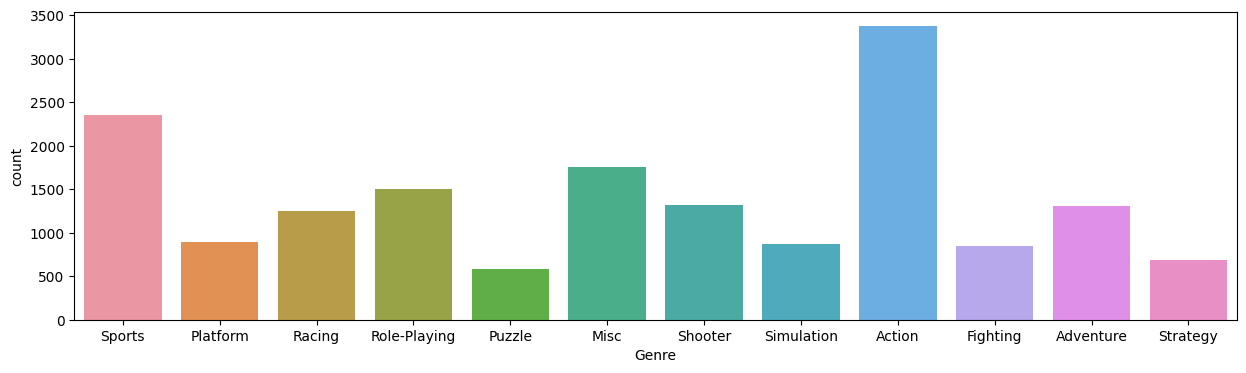

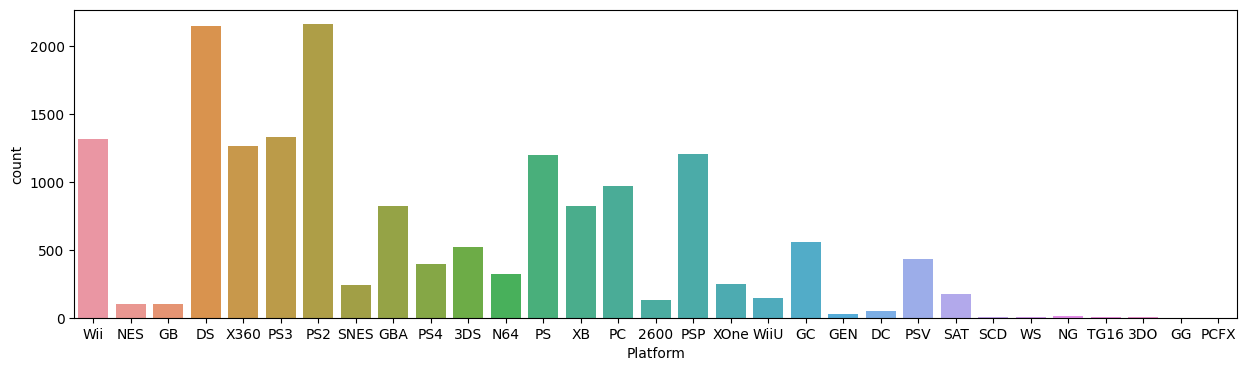

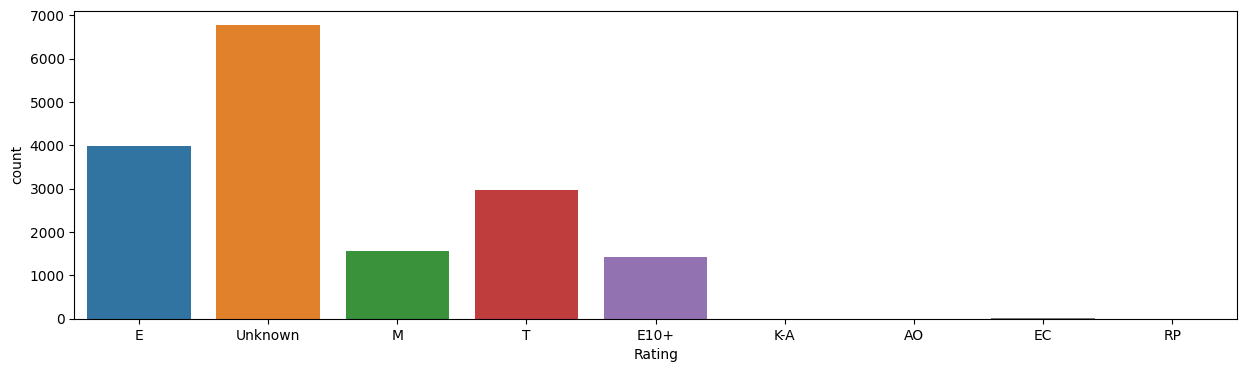

In [501]:
features = video_games_filtered_df[['Genre', 'Platform', 'Rating']].columns

for idx, feature in enumerate(features):
    plt.figure(figsize = (15,4))
    sns.countplot(data=video_games_filtered_df, x=feature)
plt.show()

Remove from the dataset any games that have a rating of 'Unknown'

In [502]:
video_games_filtered_df = video_games_filtered_df.query("Rating != 'Unknown'")
video_games_filtered_df['Rating'].value_counts()

E       3991
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
Name: Rating, dtype: int64

Create additional features that correspond to the `User_Score` and `Critic_score` variables, and replace any missing or 'tbd' values with a specific substitute. The substitute will be calculated as the mean value of the `User_Score` or `Critic_score` variable within a particular genre, such as the average of all scores under the 'Action' category.

In [503]:
# Replace 'tbd' value to NaN
video_games_filtered_df['User_Score'] = np.where(video_games_filtered_df['User_Score'] == 'tbd', np.nan, video_games_filtered_df['User_Score']).astype(float)

# Group the records by Genre, then aggregate them calculating the average of both  Critic Score and User Score
video_game_score_mean = video_games_filtered_df[['Genre', 'Critic_Score', 'User_Score']].groupby('Genre', as_index=False).agg(Ave_Critic_Score = ('Critic_Score', 'mean'), 
                                                                                                                              Ave_User_Score = ('User_Score', 'mean'))

# Merge the average scores with the main dataframe
video_games_filtered_df = video_games_filtered_df.merge(video_game_score_mean, on='Genre')
video_games_filtered_df

,Name,Platform,Genre,Critic_Score,User_Score,Rating,Ave_Critic_Score,Ave_User_Score
0,Wii Sports,Wii,Sports,76.0,8.0,E,72.037257,6.973126
1,Wii Sports Resort,Wii,Sports,80.0,8.0,E,72.037257,6.973126
2,Wii Fit,Wii,Sports,80.0,7.7,E,72.037257,6.973126
3,Wii Fit Plus,Wii,Sports,80.0,7.4,E,72.037257,6.973126
4,FIFA 16,PS4,Sports,82.0,4.3,E,72.037257,6.973126
...,...,...,...,...,...,...,...,...
9945,The Eye of Judgment: Legends,PSP,Strategy,69.0,7.9,E10+,72.254296,7.320930
9946,Hospital Tycoon,PC,Strategy,51.0,3.8,E10+,72.254296,7.320930
9947,End of Nations,PC,Strategy,NaN,NaN,T,72.254296,7.320930
9948,Worms 2,PC,Strategy,NaN,8.1,K-A,72.254296,7.320930


In [504]:
video_games_filtered_df['Critic_Score_Upd'] = np.where(video_games_filtered_df['Critic_Score'].isna(), video_games_filtered_df['Ave_Critic_Score'], video_games_filtered_df['Critic_Score'])
video_games_filtered_df['User_Score_Upd'] = np.where(video_games_filtered_df['User_Score'].isna(),  video_games_filtered_df['Ave_User_Score'], video_games_filtered_df['User_Score'])
video_games_filtered_df

,Name,Platform,Genre,Critic_Score,User_Score,Rating,Ave_Critic_Score,Ave_User_Score,Critic_Score_Upd,User_Score_Upd
0,Wii Sports,Wii,Sports,76.0,8.0,E,72.037257,6.973126,76.000000,8.00000
1,Wii Sports Resort,Wii,Sports,80.0,8.0,E,72.037257,6.973126,80.000000,8.00000
2,Wii Fit,Wii,Sports,80.0,7.7,E,72.037257,6.973126,80.000000,7.70000
3,Wii Fit Plus,Wii,Sports,80.0,7.4,E,72.037257,6.973126,80.000000,7.40000
4,FIFA 16,PS4,Sports,82.0,4.3,E,72.037257,6.973126,82.000000,4.30000
...,...,...,...,...,...,...,...,...,...,...
9945,The Eye of Judgment: Legends,PSP,Strategy,69.0,7.9,E10+,72.254296,7.320930,69.000000,7.90000
9946,Hospital Tycoon,PC,Strategy,51.0,3.8,E10+,72.254296,7.320930,51.000000,3.80000
9947,End of Nations,PC,Strategy,NaN,NaN,T,72.254296,7.320930,72.254296,7.32093
9948,Worms 2,PC,Strategy,NaN,8.1,K-A,72.254296,7.320930,72.254296,8.10000


Check again if there are any features with missing values, excluding `Critic_Score` and `User_Score` since these features will be replaced by `Critic_Score_Upd` and `User_Score_Upd`

In [505]:
video_games_final_df = video_games_filtered_df.drop(columns=['User_Score', 'Critic_Score', 'Ave_Critic_Score', 'Ave_User_Score'], axis=1)
video_games_final_df = video_games_final_df.reset_index(drop=True)

video_games_final_df = video_games_final_df.rename(columns={'Critic_Score_Upd':'Critic_Score', 'User_Score_Upd':'User_Score'})
video_games_final_df.isna().sum().sort_values(ascending=False)

Name            0
Platform        0
Genre           0
Rating          0
Critic_Score    0
User_Score      0
dtype: int64

Examine and compare the summary statistics of `User_Score` and `Critic_Score` and their respective new features (`User_Score_Upd` and `Critic_Score_Upd`) with imputed missing values. Below shows that filling in the missing values did not have an impact on the average of the data. The standard deviation of the critic score has gone down by around 4, as expected, and a marginal difference for user score.

In [506]:
video_games_filtered_df[['Critic_Score', 'Critic_Score_Upd',  'User_Score', 'User_Score_Upd']].describe()

,Critic_Score,Critic_Score_Upd,User_Score,User_Score_Upd
count,8054.000000,9950.000000,7504.000000,9950.000000
mean,68.971319,68.851751,7.126879,7.107768
std,13.951640,12.594336,1.500750,1.305869
min,13.000000,13.000000,0.000000,0.000000
25%,60.000000,63.000000,6.400000,6.800000
50%,71.000000,69.000000,7.500000,7.136686
75%,79.000000,77.000000,8.200000,8.000000
max,98.000000,98.000000,9.700000,9.700000


Analyze the data distribution for `Critic_Score` and `User_Score`, and assess the correlation between these features.

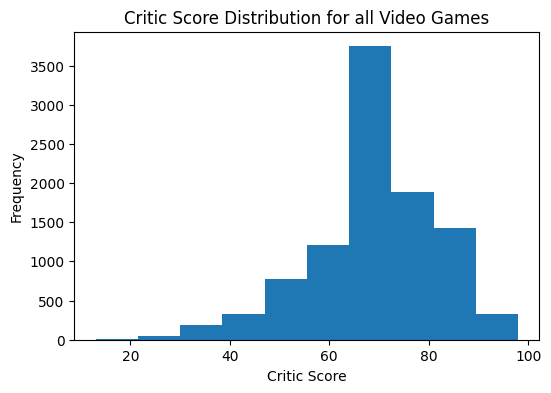

In [507]:
plt.figure(figsize=(6,4))
plt.hist(video_games_final_df['Critic_Score'], bins=10)
plt.xlabel('Critic Score')
plt.ylabel('Frequency')
plt.title("Critic Score Distribution for all Video Games")
plt.show()

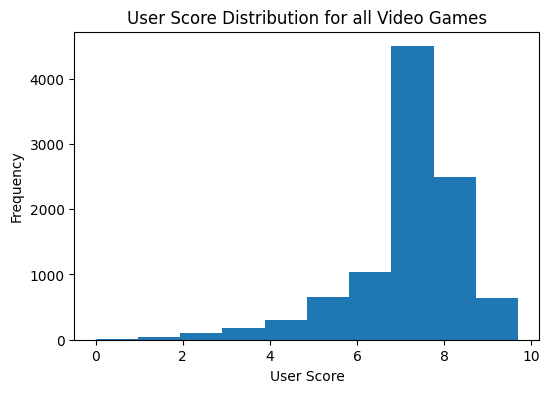

In [508]:
plt.figure(figsize=(6,4))
plt.hist(video_games_final_df['User_Score'], bins=10)
plt.xlabel('User Score')
plt.ylabel('Frequency')
plt.title("User Score Distribution for all Video Games")
plt.show()

[Text(0.5, 0, 'User Score'),
 Text(0, 0.5, 'Critic Score'),
 Text(0.5, 1.0, 'User Scores vs. Critic Scores')]

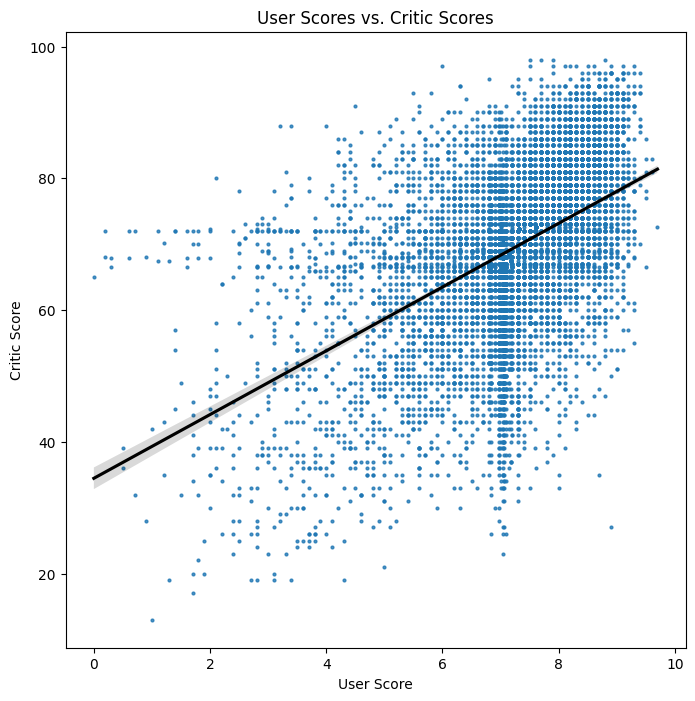

In [509]:
plt.figure(figsize=(8, 8))
ax = sns.regplot(x=video_games_final_df['User_Score'], y=video_games_final_df['Critic_Score'], line_kws={"color": "black"}, scatter_kws={'s': 4})
ax.set(xlabel ="User Score", ylabel = "Critic Score", title="User Scores vs. Critic Scores")

Perform a last verification of the dataframe details prior to transforming the categorical attributes into dummary indicators.

In [510]:
video_games_final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9950 entries, 0 to 9949
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          9950 non-null   object 
 1   Platform      9950 non-null   object 
 2   Genre         9950 non-null   object 
 3   Rating        9950 non-null   object 
 4   Critic_Score  9950 non-null   float64
 5   User_Score    9950 non-null   float64
dtypes: float64(2), object(4)
memory usage: 466.5+ KB


### Converting Categorical Features to Dummy Indicators

Get all categorical features

In [511]:
categorical_columns = [name for name in video_games_final_df.columns if video_games_final_df[name].dtype=='O']

print(f'There are {len(categorical_columns)} categorical features:\n')
print(", ".join(categorical_columns))

There are 4 categorical features:

Name, Platform, Genre, Rating


Transform all categorical attributes into binary dummy variables where the value is 0 (representing No) or 1 (representing Yes).

In [512]:
video_games_df_dummy = pd.get_dummies(data=video_games_final_df, columns=categorical_columns[1:])

video_games_df_dummy.head(5)

,Name,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,...,Genre_Sports,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_EC,Rating_K-A,Rating_M,Rating_RP,Rating_T
0,Wii Sports,76.0,8.0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
1,Wii Sports Resort,80.0,8.0,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
2,Wii Fit,80.0,7.7,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
3,Wii Fit Plus,80.0,7.4,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,FIFA 16,82.0,4.3,0,0,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0


In [513]:
video_games_df_dummy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9950 entries, 0 to 9949
Data columns (total 40 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Name                9950 non-null   object 
 1   Critic_Score        9950 non-null   float64
 2   User_Score          9950 non-null   float64
 3   Platform_3DS        9950 non-null   uint8  
 4   Platform_DC         9950 non-null   uint8  
 5   Platform_DS         9950 non-null   uint8  
 6   Platform_GBA        9950 non-null   uint8  
 7   Platform_GC         9950 non-null   uint8  
 8   Platform_PC         9950 non-null   uint8  
 9   Platform_PS         9950 non-null   uint8  
 10  Platform_PS2        9950 non-null   uint8  
 11  Platform_PS3        9950 non-null   uint8  
 12  Platform_PS4        9950 non-null   uint8  
 13  Platform_PSP        9950 non-null   uint8  
 14  Platform_PSV        9950 non-null   uint8  
 15  Platform_Wii        9950 non-null   uint8  
 16  Platfo

### Standardizing the Numerical Features

Transform numerical data to a standardized form by scaling them to have a mean of 0 and a standard deviation of 1. The purpose of standardization is to ensure that all features are on a similar scale and have equal importance in determining the output variable.

In [514]:
features = video_games_df_dummy.drop(columns=['Name'], axis=1)

scale = StandardScaler()
scaled_features = scale.fit_transform(features)
scaled_features = pd.DataFrame(scaled_features, columns=features.columns)

scaled_features.head(5)

,Critic_Score,User_Score,Platform_3DS,Platform_DC,Platform_DS,Platform_GBA,Platform_GC,Platform_PC,Platform_PS,Platform_PS2,...,Genre_Sports,Genre_Strategy,Rating_AO,Rating_E,Rating_E10+,Rating_EC,Rating_K-A,Rating_M,Rating_RP,Rating_T
0,0.567605,0.683282,-0.15314,-0.037537,-0.3832,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,2.365115,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
1,0.885224,0.683282,-0.15314,-0.037537,-0.3832,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,2.365115,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
2,0.885224,0.453538,-0.15314,-0.037537,-0.3832,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,2.365115,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
3,0.885224,0.223794,-0.15314,-0.037537,-0.3832,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,2.365115,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896
4,1.044034,-2.150224,-0.15314,-0.037537,-0.3832,-0.235302,-0.222413,-0.290432,-0.146119,-0.418178,...,2.365115,-0.187809,-0.010026,1.221929,-0.408009,-0.028367,-0.017367,-0.431694,-0.017367,-0.650896


### Creating a Model

We will use `NearestNeighbors` model to find similar items. It is a machine learning algorithm that belongs to the category of unsupervised learning algorithms, which is used for finding the k-nearest neighbors of a data point or a set of data points in a given dataset.

In [515]:
nn = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(scaled_features)
print(nn)

vg_distances, vg_indices = nn.kneighbors(scaled_features)

NearestNeighbors(algorithm='ball_tree', n_neighbors=10)


### Testing the Model

In [516]:
def VideoGameRecommender(video_game_name, video_game_platform=None):

    if video_game_platform == None:
        video_game_idx = video_games_final_df.query("Name == @video_game_name").index
    else:
        video_game_idx = video_games_final_df.query("Name == @video_game_name & Platform == @video_game_platform").index

        if video_game_idx.empty:
            print(f"Note: The game is not available on the specified platform. The recommendations will rely solely on the game's title.\n")

            video_game_idx = video_games_final_df.query("Name == @video_game_name").index
            video_game_platform = None
    
    if video_game_idx.empty:
        print(f"The game '{video_game_name}' doesn't exist in the record.")
        return None
    
    else :
        recommended_idx = vg_indices[video_game_idx[0]]

        if video_game_platform == None:
            
            vg_combined_dist_idx_df = pd.DataFrame()

            for idx in video_game_idx:
                vg_dist_idx_df = pd.concat([pd.DataFrame(vg_indices[idx]), pd.DataFrame(vg_distances[idx])], axis=1)
                vg_combined_dist_idx_df = pd.concat([vg_combined_dist_idx_df, vg_dist_idx_df])

            vg_combined_dist_idx_df = vg_combined_dist_idx_df.set_axis(['Index', 'Distance'], axis=1, inplace=False).reset_index(drop=True)
            vg_combined_dist_idx_df = vg_combined_dist_idx_df.sort_values(by='Distance', ascending=True)

            video_game_list = video_games_final_df.iloc[vg_combined_dist_idx_df['Index']]

            # Remove from the list any game that shares the same name as the input
            video_game_list = video_game_list.query('Name != @video_game_name')

            # Remove any duplicate game names to provide the user with a diverse selection of recommended games
            video_game_list = video_game_list.drop_duplicates(subset=['Name'], keep='first')

            # Get the first 10 games in the list
            video_game_list = video_game_list.head(10)

        else:
            video_game_list = video_games_final_df.iloc[recommended_idx]
        

        video_game_list = video_game_list.sort_values(by=['User_Score', 'Critic_Score'], ascending=[False, False])

        print(f"Top 10 Recommended Video Games for '{video_game_name}' [platform:{video_game_platform}]")

        display(video_game_list.style.hide_index())

__Test data #1__

The user has provided only the game title as input

In [523]:
VideoGameRecommender('Call of Duty: Finest Hour')

Top 10 Recommended Video Games for 'Call of Duty: Finest Hour' [platform:None]


Name,Platform,Genre,Rating,Critic_Score,User_Score
Robotech: Battlecry,GC,Shooter,T,74.000000,8.400000
Call Of Duty 2: Big Red One,PS2,Shooter,T,77.000000,8.200000
Kill.Switch,XB,Shooter,T,75.000000,8.000000
James Bond 007: Nightfire,XB,Shooter,T,78.000000,7.800000
Close Combat: First to Fight,XB,Shooter,T,69.000000,7.800000
Silpheed: The Lost Planet,PS2,Shooter,T,72.000000,7.500000
Blood Wake,XB,Shooter,T,71.000000,7.500000
James Bond 007: Agent Under Fire,XB,Shooter,T,71.000000,7.500000
America's Army: Rise of a Soldier,XB,Shooter,T,70.000000,7.400000
Gunvalkyrie,XB,Shooter,T,73.000000,7.300000


__Test data #2__

The user has provided the game title and the platform as input

In [522]:
VideoGameRecommender('Call of Duty: Finest Hour', 'PS2')

Top 10 Recommended Video Games for 'Call of Duty: Finest Hour' [platform:PS2]


Name,Platform,Genre,Rating,Critic_Score,User_Score
Alien Hominid,PS2,Shooter,T,78.000000,8.300000
Call Of Duty 2: Big Red One,PS2,Shooter,T,77.000000,8.200000
Metal Slug Anthology,PS2,Shooter,T,80.000000,8.100000
TimeSplitters,PS2,Shooter,T,81.000000,8.000000
Time Crisis II,PS2,Shooter,T,81.000000,7.900000
James Bond 007: Agent Under Fire,PS2,Shooter,T,72.000000,7.900000
Syphon Filter: Logan's Shadow,PS2,Shooter,T,70.189362,7.900000
Syphon Filter: Dark Mirror,PS2,Shooter,T,70.000000,7.800000
Call of Duty: Finest Hour,PS2,Shooter,T,76.000000,7.700000
Silpheed: The Lost Planet,PS2,Shooter,T,72.000000,7.500000


__Test data #3__

The user has provided the game title and the platform as input. However, the game is not available on the specified platform. Given this scenario, recommendations will solely be based on the game title.

In [524]:
VideoGameRecommender('Call of Duty: Finest Hour', 'Wii')

Note: The game is not available on the specified platform. The recommendations will rely solely on the game's title.

Top 10 Recommended Video Games for 'Call of Duty: Finest Hour' [platform:None]


Name,Platform,Genre,Rating,Critic_Score,User_Score
Robotech: Battlecry,GC,Shooter,T,74.000000,8.400000
Call Of Duty 2: Big Red One,PS2,Shooter,T,77.000000,8.200000
Kill.Switch,XB,Shooter,T,75.000000,8.000000
James Bond 007: Nightfire,XB,Shooter,T,78.000000,7.800000
Close Combat: First to Fight,XB,Shooter,T,69.000000,7.800000
Silpheed: The Lost Planet,PS2,Shooter,T,72.000000,7.500000
Blood Wake,XB,Shooter,T,71.000000,7.500000
James Bond 007: Agent Under Fire,XB,Shooter,T,71.000000,7.500000
America's Army: Rise of a Soldier,XB,Shooter,T,70.000000,7.400000
Gunvalkyrie,XB,Shooter,T,73.000000,7.300000


__Test data #4__

The user has provided only the game title as input. However, the game does not exist in the record.

Test games and/platform that is not included in the dataset to train the predictive model

In [525]:
VideoGameRecommender('Wii Sport IV', 'Wii')

Note: The game is not available on the specified platform. The recommendations will rely solely on the game's title.

The game 'Wii Sport IV' doesn't exist in the record.


### Assumptions

### Conclusions

### References

1. https://www.kaggle.com/datasets/rush4ratio/video-game-sales-with-ratings
2. https://thecleverprogrammer.com/2021/01/17/book-recommendation-system/

> BDM-3014 Winter 2023 Project (Group 12)